In [ ]:
!pip install darts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from darts.models import NHiTSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import pandas as pd

In [ ]:
train_for = 735

In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
df=df.groupby(['Date']).agg({'F_pos': 'sum', 'M_pos': 'sum', 'T_pos':'sum', 'NIA_pos':'sum', 'new_case': 'sum'}).reset_index()

date = str(df.iloc[train_for + 1]['Date'])

df_f = df['F_pos'].values
df_m = df['M_pos'].values
df_t = df['T_pos'].values
df_nia = df['NIA_pos'].values

df = df_f + df_m + df_t + df_nia

In [ ]:
df = smoothen(df, 3)

In [ ]:
series = TimeSeries.from_values(df)

In [ ]:

predict_for = 14
window_size= 50
train, test = series[:train_for], series[train_for:train_for+predict_for]

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
        monitor="train_loss",
        patience=5,
        min_delta=0.000000001,
        mode='min',
    )

pl_trainer_kwargs={"callbacks": [my_stopper]}

In [ ]:
model = NHiTSModel(
    input_chunk_length = window_size,
    output_chunk_length = 1,
    pl_trainer_kwargs = pl_trainer_kwargs,
    dropout=0.15
)

In [ ]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [ ]:
model.fit(
    scaled_train,
    epochs = 100
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 901 K 
---------------------------------------------------
875 K     Trainable params
25.7 K    Non-trainable params
901 K     Total params
3.605     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
scaled_pred_nhits = model.predict(n=14)

pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [ ]:
from darts.metrics import mape

mape_nhits = mape(test, pred_nhits)

print(mape_nhits)

9.47545742174797


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
actual = test.pd_dataframe().values.reshape(-1)
predictions = pred_nhits.pd_dataframe().values.reshape(-1)
print(actual.reshape(-1))

[205228.         191578.66666667 219443.33333333 247295.66666667
 297296.         298543.         290942.33333333 284577.
 248668.33333333 290140.         322144.33333333 384948.33333333
 375075.66666667 367394.33333333]


In [ ]:
print(predictions)

[181312.1234446  194873.01578278 205586.69789917 221146.33685852
 238778.42878765 259370.20961411 279425.90053845 297640.44435174
 314835.17411652 331832.74871904 347911.19857942 363735.77612036
 377255.49464417 389338.77187104]


In [ ]:
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

In [ ]:
window = 100

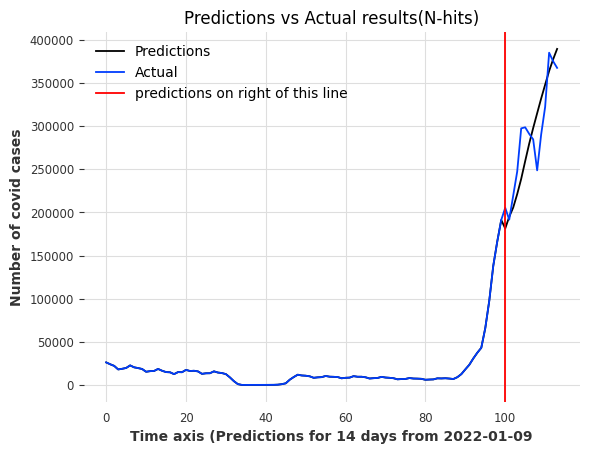

In [ ]:
plt.figure()
plt.title("Predictions vs Actual results(N-hits)")
plt.plot(append(df[train_for - window:train_for], predictions), label="Predictions")
plt.plot(append(df[train_for - window:train_for], actual), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
model.save("Nhits" + date + ".pt")